<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Upload-Dicom-Image" data-toc-modified-id="Upload-Dicom-Image-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Upload Dicom Image</a></span></li><li><span><a href="#Preprocess-Data" data-toc-modified-id="Preprocess-Data-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Preprocess Data</a></span><ul class="toc-item"><li><span><a href="#Preprocess-input" data-toc-modified-id="Preprocess-input-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Preprocess input</a></span><ul class="toc-item"><li><span><a href="#Resize-Volume" data-toc-modified-id="Resize-Volume-2.1.1"><span class="toc-item-num">2.1.1&nbsp;&nbsp;</span>Resize Volume</a></span></li><li><span><a href="#Decompose-Volume-into-minicubes" data-toc-modified-id="Decompose-Volume-into-minicubes-2.1.2"><span class="toc-item-num">2.1.2&nbsp;&nbsp;</span>Decompose Volume into minicubes</a></span></li></ul></li><li><span><a href="#Split-Y-into-minicubes" data-toc-modified-id="Split-Y-into-minicubes-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Split Y into minicubes</a></span></li><li><span><a href="#Prepare-Data-into-the-format-expected-by-the-model" data-toc-modified-id="Prepare-Data-into-the-format-expected-by-the-model-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Prepare Data into the format expected by the model</a></span></li></ul></li><li><span><a href="#Make-a-prdiction-on-each-cube" data-toc-modified-id="Make-a-prdiction-on-each-cube-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Make a prdiction on each cube</a></span></li><li><span><a href="#Post-Processing:-Concatenate-cubes" data-toc-modified-id="Post-Processing:-Concatenate-cubes-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Post-Processing: Concatenate cubes</a></span></li><li><span><a href="#Visualize" data-toc-modified-id="Visualize-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Visualize</a></span></li></ul></div>

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib nbagg

In [2]:
import sys
sys.path.insert(0,"./src")

In [3]:
import pylidc as pl #pip install -Iv scikit-image==0.13
from random import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
import scipy
import random
import os
from imports import *
import mxnet as mx

# Upload Dicom Image

In [4]:
#file = '/media/mas/Untitled/LIDC/DOI/LIDC-IDRI-0005/1.3.6.1.4.1.14519.5.2.1.6279.6001.190188259083742759886805142125/1.3.6.1.4.1.14519.5.2.1.6279.6001.129007566048223160327836686225/'

In [5]:
scan_id =12
scan_1 = ctscan(scan_id) 

Loading dicom files ... This may take a moment.


# Preprocess Data

## Preprocess input 

### Resize Volume

In [6]:
Vol0=scan_1.image_normalized #zxy
Kn,In,Jn=Vol0.shape

In = In//32*32
Jn = Jn//32*32
Kn = Kn//32*32

print(Kn,In,Jn)

Vol0=Vol0[:Kn,:In,:Jn].copy()
print(Vol0.shape)

Scann=Vol0.copy()

320 352 352
(320, 352, 352)


### Decompose Volume into minicubes

In [7]:
Vol1=[]

for k in range(0,Kn,32):
    for i in range(0,In,32):
        for j in range(0,Jn,32):
            Vol1.append(Vol0[k:k+32,i:i+32,j:j+32])

#plt.imshow(Vol0[0,:,:])

len(Vol1),Vol1[-1].shape

(1210, (32, 32, 32))

In [8]:
X_train = Vol1.copy()

## Split Y into minicubes

In [9]:
Vol0=scan_1.Z2 #zxy
Vol0=Vol0[:Kn,:In,:Jn].copy()

Vol1=[]

for k in range(0,Kn,32):
    for i in range(0,In,32):
        for j in range(0,Jn,32):
            Vol1.append(Vol0[k:k+32,i:i+32,j:j+32])

#plt.imshow(Vol0[0,:,:])

In [10]:
Y_train = Vol1.copy()

## Prepare Data into the format expected by the model

In [11]:
X_train2 = [ np.expand_dims(e, axis=0) for e in X_train]

X_train3 = np.array(X_train2)

mean_image =.27
std_image = .27

X_train4= X_train3 - mean_image
X_train4 = X_train4/std_image
X_train4.shape

(1210, 1, 32, 32, 32)

In [12]:
Y_train2 = [j.reshape((32*32*32)) for j in Y_train]

#Y_train2 = [ np.expand_dims(e, axis=0) for e in Y_train2]
#Y_train2[-1].shape

Y_train3 = np.array(Y_train2)

Y_train3.shape


(1210, 32768)

# Make a prdiction on each cube

In [13]:
model_path = "/home/mas/x110/model/oct31"
model_epoch=400

In [14]:
bs=44 #note that the bs should be a divisor of the number of data in the iterator.
train_iter = mx.io.NDArrayIter(X_train4, Y_train3, batch_size=bs)
input_shapes = dict(train_iter.provide_data+train_iter.provide_label)
print ('input_shapes', input_shapes)

input_shapes {'data': (44, 1, 32, 32, 32), 'softmax_label': (44, 32768)}


In [15]:
network, arg_params, aux_params = mx.model.load_checkpoint(model_path , model_epoch)

# Binding
exe = network.simple_bind(ctx=mx.gpu(0), **input_shapes)
# get handle to input arrays
arg_arrays = dict(zip(network.list_arguments(), exe.arg_arrays))
data = arg_arrays[train_iter.provide_data[0][0]]
label = arg_arrays[train_iter.provide_label[0][0]]


exe.copy_params_from(arg_params, aux_params)

In [16]:
K = train_iter.num_data
ps=[]
train_iter.reset()
for batch in train_iter:

    data[:] = batch.data[0]       
    label[:] = batch.label[0]

    outputs = exe.forward(is_train=False)
    p = outputs[0].asnumpy()
    ps.append(p)
w = [xx.reshape(32,32,32) for x in ps for xx in list(x)]

In [17]:
Y_train3.shape

(1210, 32768)

In [18]:
len(w),32*32*32

(1232, 32768)

In [19]:
len(list(Y_train3))

1210

# Post-Processing: Concatenate cubes

In [22]:
#d = list(Y_train3)
#len(d),d[0].shape
#d = [x.reshape(32,32,32) for x in d]

In [23]:
Vol1=w.copy()
A=np.zeros((Kn,In,Jn))
m=0

for k in range(0,Kn,32):
    for i in range(0,In,32):
        for j in range(0,Jn,32):
            z,x,y=np.array(Vol1[m]).shape
            A[k:k+z,i:i+x,j:j+y]=Vol1[m]
            m=m+1

# Visualize

<IPython.core.display.Javascript object>


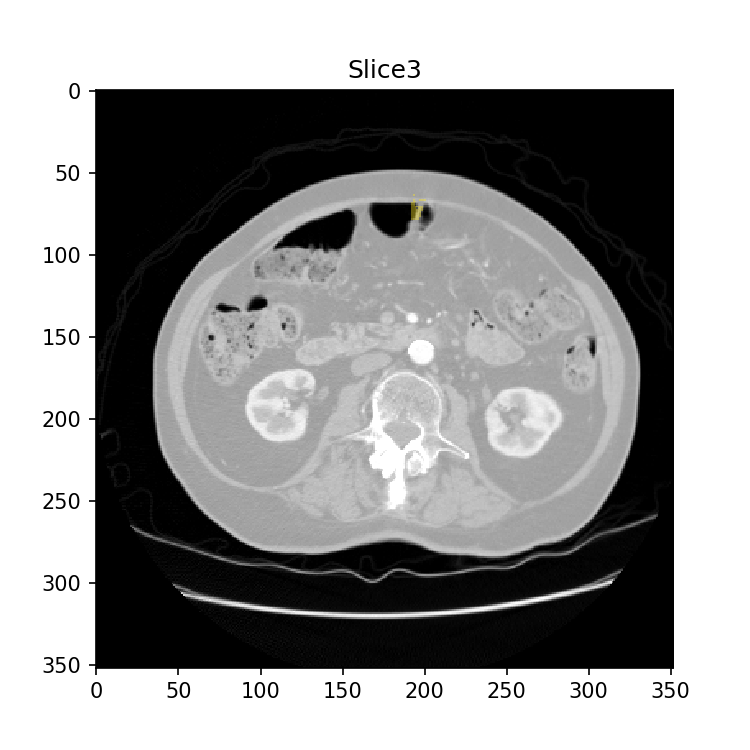

In [24]:
image3d=scan_1.image_normalized
Y = scan_1.Z2
p = np.array(A)

Y= np.ma.masked_where(Y == 0, Y)
msk2 = p>.5#.001
msk2=msk2*1
msk2= np.ma.masked_where(msk2 == 0, msk2)

fig = plt.figure(figsize=(5,5)) # make figure
ax = plt.subplot(1,1,1)
im = plt.imshow(image3d[0],'gray',vmin=0,vmax=1)
im2 = plt.imshow(Y[0],interpolation='none', cmap=plt.cm.Reds, alpha=.7, vmin=0, vmax=1)
im3 = plt.imshow(msk2[0],interpolation='none', alpha=.4, vmin=0, vmax=1)


ztot=5
rects=[patches.Rectangle((512,512),1,1,linewidth=1,edgecolor='r',facecolor='none') for i in range(ztot)]




for r in rects:
    ax.add_patch(r)



# function to update figure
def updatefig(j):
    # set the data in the axesimage object
    im.set_array(image3d[j])
    im2.set_array(Y[j])
    im3.set_array(msk2[j])



    for i in range(ztot):
        if i <len(scan_1.Zbbox[j]):
            rects[i].set_xy(scan_1.Zbbox[j][i][0:2])
            rects[i].set_height(scan_1.Zbbox[j][i][2])
            rects[i].set_width(scan_1.Zbbox[j][i][3])
        else:
            rects[i].set_xy([512,512])


    ax.set_title("Slice"+str(j))
    return im,im2,im3,rects

# kick off the animation
ani = animation.FuncAnimation(fig, updatefig, frames=range(len(image3d)),
                              interval=50, blit=True)
#ani.save('Chest_Cavity5.gif', writer='imagemagick')